# Corss validation techniques

Choosing the **right cross-validation** depends on the dataset you are dealing with, and one’s choice of cross-validation on one dataset may or may not apply to other datasets.

there are a few types of cross-validation techniques which are the most popular and widely used

    • k-fold cross-validation
    • stratified k-fold cross-validation
    • hold-out based validation
    • leave-one-out cross-validation
    • group k-fold cross-validation

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('data/winequality-red.csv')
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)
kf = model_selection.KFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df)):
    df.loc[val_, 'kfold'] = fold
df.to_csv('data/wine_data_folds.csv', index=False)

In [17]:
kfold_data = pd.read_csv('data/wine_data_folds.csv')
kfold_data.kfold.value_counts()

3    320
2    320
1    320
0    320
4    319
Name: kfold, dtype: int64

all folds have equal number of samples

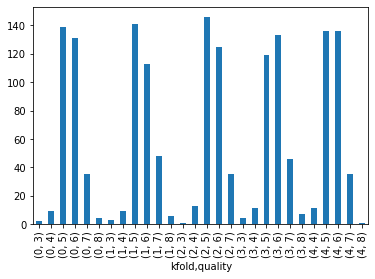

In [29]:
kfold_data.groupby(['kfold', 'quality']).quality.count().plot.bar()

## stratified k-fold

when we have skewed dataset for binary classification with 90% positive samples and only 10% negative samples, you don't want to use random k-fold cross-validation. That results in having all positives values in some folds.

In these cases, we prefer using stratified k-fold cross-validation. Stratified k-fold cross-validation keeps the ratio of labels in each fold constant

In [31]:
df = pd.read_csv('data/winequality-red.csv')
df['kfold'] = -1
df = df.sample(frac=1).reset_index(drop=True)

y = df.quality.values
kf = model_selection.StratifiedKFold(n_splits=5)

for fold, (trn_, val_) in enumerate(kf.split(X=df, y=y)):
    df.loc[val_, 'kfold'] = fold

#store folds in a file
df.to_csv('data/wine_data_stratified_folds.csv')

Text(0, 0.5, 'count')

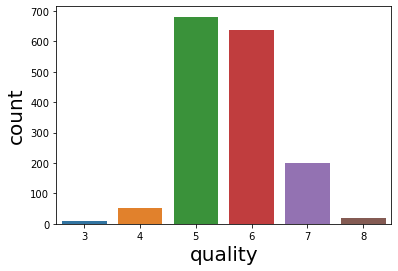

In [32]:
b = sns.countplot(x='quality', data=df)
b.set_xlabel('quality', fontsize=20)
b.set_ylabel('count', fontsize=20)

In [33]:
strat_kfold_data = pd.read_csv('data/wine_data_stratified_folds.csv')
strat_kfold_data.kfold.value_counts()

3    320
2    320
1    320
0    320
4    319
Name: kfold, dtype: int64

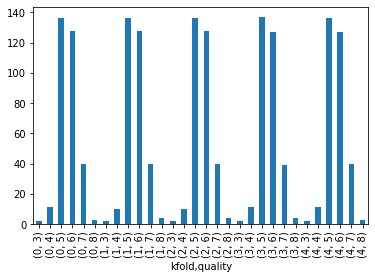

In [37]:
strat_kfold_data.groupby(['kfold', 'quality']).quality.count().plot.bar()

we can see there are some fluctuations in data distrubutions in before k-fold strategy. <br>
Using strafied k-fold technique every fold will have same ratio of target values

## hold-out based validation

There will be two sets, training and validation

The process for creating the hold-out remains the same as stratified k-fold. For a dataset which has 1 million samples, we can create ten folds instead of 5 and keep one of those folds as hold-out. This means we will have 100k samples in the holdout, and we will always calculate loss, accuracy and other metrics on this set and train on 900k samples.

Hold-out is also used very frequently with **time-series** data. Let’s assume the problem we are provided with is predicting sales of a store for 2020, and you are provided all the data from 2015-2019. In this case, you can select all the data for 2019 as a hold-out and train your model on all the data from 2015 to 2018.

## Leave one out cross validation

The value for k is fixed to n, where n is the size of the dataset to give each test sample an opportunity to be used in the hold out dataset. This approach is called **leave-one-out cross-validation**

That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point. As before the average error is computed and used to evaluate the model. The evaluation given by leave-one-out cross validation error (LOO-XVE) is good, but at first pass it seems very expensive to compute. 

https://www.cs.cmu.edu/~schneide/tut5/node42.html

## GroupKFold

If we have groups in our data, then data related to a group which is in training dataset shouldn't appear in validation. So, we have to use GroupKFold in such case. Unfortunately there is no way to combine GroupKFold with StratifiedKFold. So we have to make a way to combine both.

For example, let’s say we have a problem in which we would like to build a model to detect skin cancer from skin images of patients. Our task is to build a binary classifier which takes an input image and predicts the probability for it being benign or malignant.

In these kinds of datasets, we might have multiple images for the same patient in the training dataset.

In [1]:
from sklearn.model_selection import GroupKFold
from sklearn import datasets

In [3]:
X, y = datasets.make_classification(n_samples=20000, n_features=20, n_classes=2)
X = pd.DataFrame(X)
pd.Series(y).value_counts()

1    10001
0     9999
dtype: int64

In [4]:
groups = np.random.randint(0,100, (20000,1))

In [5]:
group_kfold = GroupKFold(n_splits=4)

In [6]:
group_kfold.get_n_splits(X, y, groups)

4

In [7]:
X['kfold'] = -1

In [8]:
for fold, (trn_, val_) in enumerate(group_kfold.split(X, y, groups)):
    X.loc[val_, 'kfold'] = fold

In [9]:
X.kfold.value_counts()

0    5007
3    5006
2    4994
1    4993
Name: kfold, dtype: int64

In [10]:
data = pd.concat([X, pd.DataFrame({'groups':pd.Series(groups.reshape(20000))})], axis=1)

In [11]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,kfold,groups
0,1.117934,0.479177,-0.261837,-0.041357,-0.830900,0.189383,0.629484,-1.223634,-0.684060,-1.307227,...,0.192872,-0.894294,0.668326,0.804813,-0.586061,-0.822005,-0.507682,-1.237189,3,54
1,0.629354,-0.409003,0.782290,0.879876,0.086827,0.254727,0.363981,0.060050,-1.147608,-1.327343,...,-0.737014,0.064265,-2.374749,1.067703,-0.169086,-0.219213,-0.985337,0.209847,3,17
2,-0.867295,1.475256,0.608560,1.830683,0.881968,0.997309,1.006055,0.783923,-0.077447,-1.498312,...,-0.381075,-1.727177,-1.322380,0.663424,-0.902081,0.352516,0.109813,-1.160554,1,70
3,-2.428720,-0.978097,-0.508069,-0.019388,-0.585806,0.867016,-0.117160,0.089576,0.343099,-0.497134,...,-0.539510,1.878179,-0.745354,0.630637,-3.754736,1.238323,0.177270,0.681478,0,13
4,-0.644117,1.691141,-1.147823,0.436639,-1.426473,1.190961,0.816713,-1.348436,-1.256749,-0.805230,...,0.429663,0.302263,0.384520,0.105266,0.153939,0.760430,0.050810,0.440371,1,21


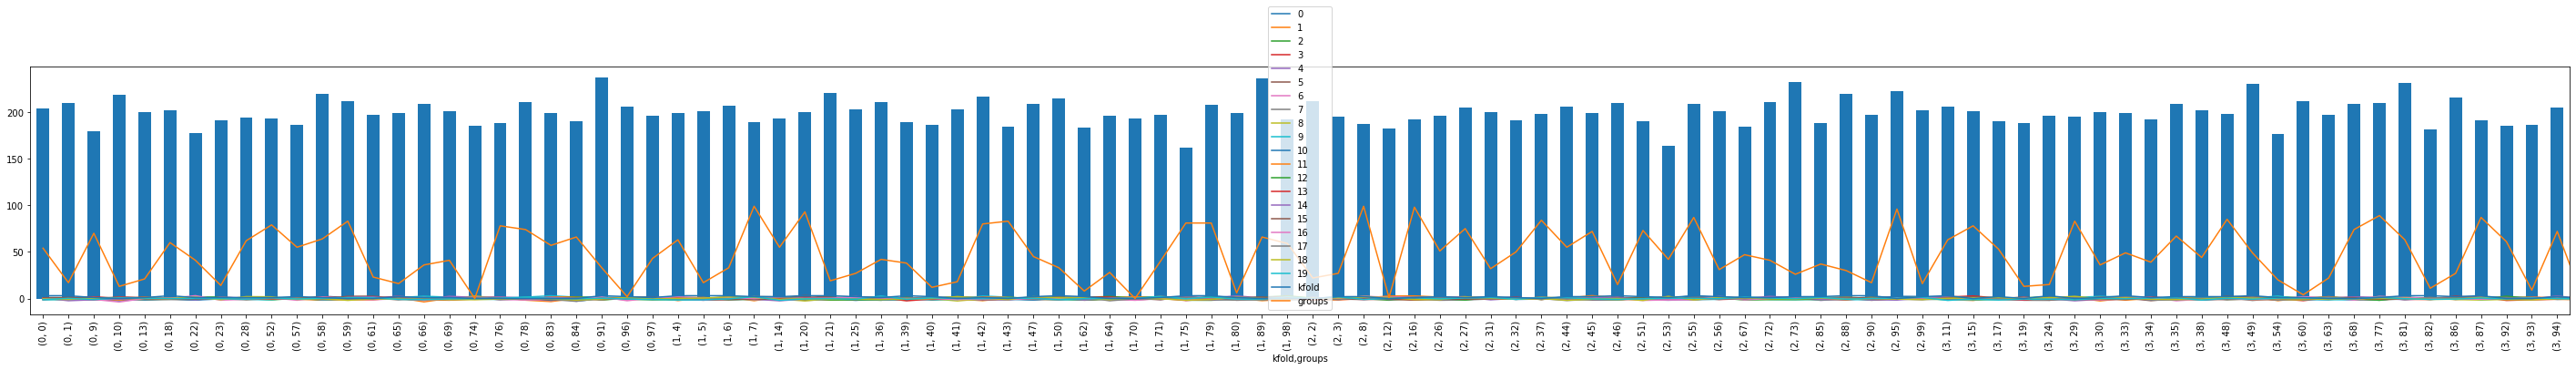

In [12]:
data.plot(figsize=(50,5))
data.groupby(['kfold', 'groups']).kfold.count().plot.bar()

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
data.groupby(['kfold', 'groups']).kfold.value_counts()

In [42]:
def group_stratified_k_fold(X, y, groups, k=5):
    num_labels = y.max() + 1
    num_groups = groups.max() + 1
    
    y_counts_per_group = defaultdict(lambda: np.zeros(num_labels))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1
    
    y_counts_per_fold = defaultdict(lambda: np.zeros(num_labels))
    groups_per_fold = defaultdict(set)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    
    for i in 
    
            

https://github.com/scikit-learn/scikit-learn/issues/13621

## Regression

All mentioned above can also be used for regression problems, expect stratified k-fold, as this depends on ratio of target samples. We can still use stratified k-fold for regression by forming bins for target value.

**Sturge’s rule:**<br>
*Number of Bins* = 1 + log2(N), where N is number of samples in dataset

In [46]:
def create_folds(df):
    n_bins = int(np.floor(1 + np.log2(df.shape[0])))
    df['kfold'] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    df['bin'] = pd.cut(df.target, bins=n_bins, labels=False)
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for fold, (trn_, val_) in enumerate(kf.split(X=df,y=df.bin.values)):
        df.loc[val_, 'kfold'] = fold
    df = df.drop('bin', axis=1)
    return df

In [47]:
from sklearn import datasets

X, y = datasets.make_regression(n_samples=15000, n_features=100, n_targets=1)
df = pd.DataFrame(X, columns=[f"f_{i}" for i in range(X.shape[1])])
df.loc[:, 'target'] = y
df = create_folds(df)

/home/divyay/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
